In [ ]:
# NYC Taxi fare Challenge from Kaggle: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import sklearn
import scipy
from sklearn.model_selection import KFold
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline 
import matplotlib.pyplot as plt


/Users/javier.noguera/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/javier.noguera/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/javier.noguera/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/javier.noguera/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/javier.noguera/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/User

In [2]:
train_df_raw = pd.read_csv('//Users/javier.noguera/Documents/taxi/all/train.csv', nrows=10000000)

In [3]:
train_df_raw.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [4]:
train_df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
# Clean up

# drop na
print(train_df_raw.isnull().values.any())
train_df_raw=train_df_raw.dropna()
print(train_df_raw.isnull().values.any())




True
False


In [6]:
train_df_raw['euc_distance']=np.sqrt(np.square(np.subtract(train_df_raw['pickup_latitude'], train_df_raw['dropoff_latitude']))+
                                     np.square(np.subtract(train_df_raw['pickup_longitude'],train_df_raw['dropoff_longitude'])))


LAT_TO_KM = 111
LONG_TO_KM = 85

    

'''
train_df_raw['euc_distance_km']=np.sqrt(np.square(np.subtract(train_df_raw['pickup_latitude'], train_df_raw['dropoff_latitude'])) * LAT_TO_KM +
                                     np.square(np.subtract(train_df_raw['pickup_longitude'],train_df_raw['dropoff_longitude'])) * LONG_TO_KM)
'''

def computeDistKm(latStart, longStart, latEnd, longEnd):
    dlat = np.subtract(latEnd, latStart)
    dlong = np.subtract(longEnd, longStart)
    dist = np.sqrt(dlat * dlat * LAT_TO_KM + dlong * dlong * LONG_TO_KM)
    return dist

def computeDistManhattanKm(latStart, longStart, latEnd, longEnd):
    dlat = np.subtract(latEnd, latStart)
    dlong = np.subtract(longEnd, longStart)
    dist = np.abs(dlat * LAT_TO_KM) + np.abs(dlong * LONG_TO_KM)
    return dist

train_df_raw['euc_distance_km'] = computeDistKm(train_df_raw['pickup_latitude'], train_df_raw['pickup_longitude'], train_df_raw['dropoff_latitude'], train_df_raw['dropoff_longitude'])
train_df_raw['man_distance_km'] = computeDistManhattanKm(train_df_raw['pickup_latitude'], train_df_raw['pickup_longitude'], train_df_raw['dropoff_latitude'], train_df_raw['dropoff_longitude'])

train_df_raw["price_dist_ratio"] = np.divide(train_df_raw["fare_amount"], train_df_raw["euc_distance_km"])
train_df_raw["price_man_dist_ratio"] = np.divide(train_df_raw["fare_amount"], train_df_raw["man_distance_km"])

# filter
train_df_raw = train_df_raw[(train_df_raw['euc_distance_km'] > 0.0) & (train_df_raw['fare_amount'] > 0)]


print(train_df_raw.shape)




/Users/javier.noguera/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/Users/javier.noguera/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/javier.noguera/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/Users/javier.noguera/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


(9713749, 13)


In [7]:
# extract days

train_df_raw['pickup_datetime']=pd.to_datetime(train_df_raw['pickup_datetime'],infer_datetime_format=True)
train_df_raw['pickup_year']=train_df_raw['pickup_datetime'].dt.year
train_df_raw['pickup_month']=train_df_raw['pickup_datetime'].dt.month
train_df_raw['pickup_weekday']=train_df_raw['pickup_datetime'].dt.weekday
train_df_raw['pickup_hour']=train_df_raw['pickup_datetime'].dt.hour

# one-hot-encoding

train_df_raw=pd.get_dummies(train_df_raw, columns=['pickup_weekday','pickup_month','pickup_hour'])




In [8]:
# get y
y = train_df_raw.iloc[:,1]


# remove columns
train_df=train_df_raw.drop(columns=['key','pickup_datetime','fare_amount','passenger_count'])
train_df.head()
print(train_df.dtypes)


pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
euc_distance            float64
euc_distance_km         float64
man_distance_km         float64
price_dist_ratio        float64
price_man_dist_ratio    float64
pickup_year               int64
pickup_weekday_0          uint8
pickup_weekday_1          uint8
pickup_weekday_2          uint8
pickup_weekday_3          uint8
pickup_weekday_4          uint8
pickup_weekday_5          uint8
pickup_weekday_6          uint8
pickup_month_1            uint8
pickup_month_2            uint8
pickup_month_3            uint8
pickup_month_4            uint8
pickup_month_5            uint8
pickup_month_6            uint8
pickup_month_7            uint8
pickup_month_8            uint8
pickup_month_9            uint8
pickup_month_10           uint8
pickup_month_11           uint8
pickup_month_12           uint8
pickup_hour_0             uint8
pickup_hour_1             uint8
pickup_h

In [9]:
print(train_df_raw.head())

                             key  fare_amount     pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  euc_distance  euc_distance_km       ...        \
0                1      0.009436         0.098454    

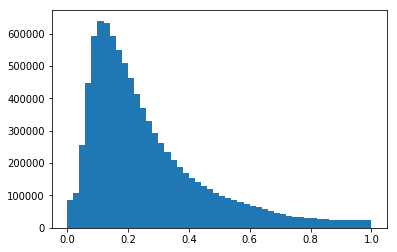

count    9.139892e+06
mean     2.652533e-01
std      1.957199e-01
min      9.219544e-06
25%      1.247637e-01
50%      2.063869e-01
75%      3.468723e-01
max      9.999997e-01
Name: euc_distance_km, dtype: float64


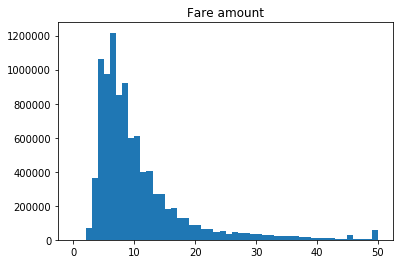

count    9.589443e+06
mean     1.069563e+01
std      7.680265e+00
min      1.000000e-02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      4.999000e+01
Name: fare_amount, dtype: float64


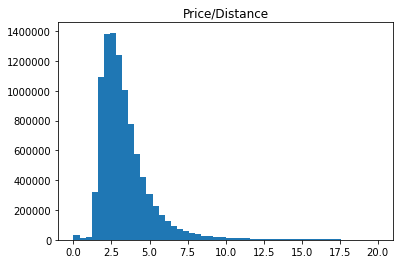

count    9.618219e+06
mean     3.391008e+00
std      1.808303e+00
min      9.249728e-07
25%      2.268540e+00
50%      2.970345e+00
75%      3.961238e+00
max      2.000000e+01
Name: price_man_dist_ratio, dtype: float64


In [10]:
reduced_df = train_df_raw[train_df_raw["euc_distance_km"] < 1]
plt.hist(reduced_df["euc_distance_km"], bins=50);
plt.show()
print(reduced_df["euc_distance_km"].describe())


#train_df_raw[train_df_raw["euc_distance_km"] < 0.00001].shape



reduced_df = train_df_raw[train_df_raw["fare_amount"] < 50]
plt.title("Fare amount")
plt.hist(reduced_df["fare_amount"], bins=50);
plt.show()

print(reduced_df["fare_amount"].describe())


reduced_df = train_df_raw[train_df_raw["price_man_dist_ratio"] < 20]
plt.title("Price/Distance")
plt.hist(reduced_df["price_man_dist_ratio"], bins=50);
plt.show()

print(reduced_df["price_man_dist_ratio"].describe())



In [11]:
# Split

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)



(7770999, 53) (7770999,)
(1942750, 53) (1942750,)


In [12]:
# Choose regressor

reg = RandomForestRegressor(verbose=True)




In [13]:
# Cross validation score

scores = cross_val_score(reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=3, verbose=True)
tree_rmse_scores = np.sqrt(-scores)

print(tree_rmse_scores)
print(np.mean(tree_rmse_scores))


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 22.9min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 27.9min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 24.3min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.3s finished


[0.55273878 0.46652904 0.62434314]
0.5478703207914771


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 75.9min finished
